<a href="https://colab.research.google.com/github/harmanpreet93/reinforcement-learning-COMP-767/blob/master/RL_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gym
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
import seaborn as sns

# ! pip install tensorflow==2.1.0
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
tf.__version__

#### Tensorflow Functional Model 

In [0]:
class Model(tf.keras.Model):

    def __init__(self, n_states, n_actions, hidden_dim=64, lr=0.05):
        super(Model, self).__init__()
        self.dense1 = tf.keras.layers.Dense(n_hidden, input_shape=(n_states,), activation='relu')
        self.dense2 = tf.keras.layers.Dense(n_hidden, activation='relu')
        self.logits = tf.keras.layers.Dense(n_actions)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.logits(x)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss_fn = tf.keras.losses.MeanSquaredError()
train_loss = tf.keras.metrics.MeanSquaredError()
train_accuracy = tf.keras.metrics.Accuracy()

@tf.function
def train_step(inputs, y_true, optimizer, loss_fn):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        y_pred = model(inputs, training=True)
        loss = loss_fn(y_true, y_pred)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return y_pred, y_true, loss

'''
dataset = tf.data.Dataset.from_tensor_slices((X,y)).batch(1)
# train model here
train_step(X, y, optimizer, loss_fn)
n_epochs = 10
for epoch in range(n_epochs):

    for minibatch in dataset:
        train_step(minibatch[0], minibatch[-1], optimizer, loss_fn)

        train_loss(loss)
        train_accuracy(y_true, y_pred)

        template = 'Episode {}, Loss: {}, Accuracy: {}'
        print(template.format(episode+1,
                        train_loss.result(),
                        train_accuracy.result()*100))
'''

#### Tensorflow High level API Model

In [3]:
def NN(n_hidden = 64, n_states=4, n_actions=2):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(n_hidden, activation='relu', input_shape=(n_states,)))
    model.add(tf.keras.layers.Dense(n_hidden, activation='relu'))
    model.add(tf.keras.layers.Dense(n_actions))
    return model

model = NN()
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________


In [0]:
def n_step_q_learning(model, memory_batch, discount_rate):
    X,y = [], []
    # generate dataset for training 
    for current_state, action, next_state, reward, done in memory_batch:
        X.append(current_state)
        current_state = current_state.reshape((1, *current_state.shape))
        q_values = model(current_state).numpy()[0]
        if done:
            q_values[action] = reward
        else:
            next_state = next_state.reshape((1, *next_state.shape))
            q_values_next = model(next_state)
            q_values[action] = reward + discount_rate * np.max(q_values_next)

        y.append(q_values)
    
    return np.array(X), np.array(y)

def n_step_SARSA(model, memory_batch, discount_rate):
    X,y = [], []
    # generate dataset for training 
    for current_state, action, next_state, reward, done in memory_batch:
        X.append(current_state)
        current_state = current_state.reshape((1, *current_state.shape))
        q_values = model(current_state).numpy()[0]
        if done:
            q_values[action] = reward
        else:
            action = e_greedy(env, model, next_state, epsilon)
            next_state = next_state.reshape((1, *next_state.shape))
            q_values_next = model(next_state)
            q_values[action] = reward + (discount_rate**4) * q_values_next[action]

        y.append(q_values)
    
    return np.array(X), np.array(y)

def experience_replay(model, memory, buffer_size, discount_rate):
    if len(memory) < buffer_size:
        return
    # sample batch from memory
    memory_batch = random.sample(memory, buffer_size)
    # get training data
    X, y = n_step_SARSA(model, memory_batch, discount_rate)
    # train model, and update weights
    model.fit(X, y, epochs=2, batch_size=buffer_size, verbose=0)

def e_greedy(env, model, state, epsilon):
    # choose action based on epsilon-greedy policy
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        input_vector = np.reshape(state, (1,*state.shape))
        Q_output = model(input_vector)
        action = np.argmax(Q_output)
    return action

def q_learning(env, model, n_episodes=100, epsilon=0.1, replay_buffer_size=50, discount_rate=0.9):
    memory = [] 
    reward_list = []

    for episode in tqdm(range(n_episodes)):
        # done = False
        current_state = env.reset()
        total_reward = 0

        while True:
            # choose action based on epsilon-greedy policy
            action = e_greedy(env, model, current_state, epsilon)

            # take chosen action
            next_state, reward, done, info = env.step(action)
            # add reward
            total_reward += reward

            # save states and action in memory
            memory.append((current_state, action, next_state, reward, done))

            if done:
                break

            experience_replay(model, memory, replay_buffer_size, discount_rate)
            current_state = next_state

        reward_list.append(total_reward)
        # plot_res(reward_list)
    
    return np.mean(reward_list[-10:])

def SARSA(env, model, n_episodes=100, epsilon=0.1, replay_buffer_size=50, discount_rate=0.9):
    memory = [] 
    reward_list = []

    for episode in tqdm(range(n_episodes)):
        # done = False
        current_state = env.reset()
        total_reward = 0

        while True:
            steps = 4
            first_state = current_state.copy()
            reward_ = 0
            while steps:
                # choose action based on epsilon-greedy policy
                action = e_greedy(env, model, current_state, epsilon)
                # take chosen action
                next_state, reward, done, info = env.step(action)
                if done:
                    break
                # gamma reward
                reward_ += (discount_rate**(4-steps)) * reward
                # add reward
                total_reward += reward_
                current_state = next_state
                steps -= 1

            # save states and action in memory
            memory.append((first_state, action, next_state, reward_, done))
            if done:
                break
            experience_replay(model, memory, replay_buffer_size, discount_rate)

        reward_list.append(total_reward)
        # plot_res(reward_list)
    
    return np.mean(reward_list[-10:])


In [0]:
def e_greedy(env, model, state, epsilon):
    # choose action based on epsilon-greedy policy
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        input_vector = np.reshape(state, (1,4))
        Q_output = model(input_vector)
        action = np.argmax(Q_output)
    return action

def greedy(env, model, state, epsilon):
    input_vector = np.reshape(state, (1,4))
    Q_output = model(input_vector)
    action = np.argmax(Q_output)
    return action

def experience_replay(model, memory, buffer_size, gamma, epsilon, n_steps=4, algorithm='sarsa'):
    if len(memory) < buffer_size:
        return
    # sample batch from memory
    memory_batch = random.sample(memory, buffer_size)
    # get training data
    X, y = n_step_algorithm(env, model, memory_batch, gamma, epsilon, n_steps, algorithm)
    # train model, and update weights
    model.fit(X, y, epochs=1, batch_size=buffer_size, verbose=0)

def n_step_algorithm(env, model, memory_batch, gamma, epsilon, n_steps=4, algorithm='sarsa'):
    X,y = [], []
    # generate dataset for training 
    for current_state, action, next_state, reward, done in memory_batch:
        X.append(current_state)
        current_state_ = current_state.copy()
        current_state_ = current_state_.reshape((1, 4))
        q_values = model(current_state_).numpy()[0]
        if done:
            q_values[action] = reward
        else:
            next_state_ = next_state.copy()
            next_state_ = next_state_.reshape((1, 4))
            q_values_next = model(next_state_).numpy()[0]
            if algorithm == 'sarsa':
                action = e_greedy(env, model, next_state_, epsilon)
                q_values[action] = reward + (gamma**n_steps) * q_values_next[action]

            elif algorithm == 'q_learning':
                q_values[action] = reward + (gamma**n_steps) * np.max(q_values_next)

            elif algorithm == 'expected_sarsa':
                q_values[action] = reward + (gamma**n_steps) * np.mean(q_values_next)

            else:
                print("Wrong algorithm given")

        y.append(q_values)

    return np.array(X), np.array(y)

def solve_deep_RL_algorithm(env, model, buffer_size=50, n_episodes=10, n_steps=4, gamma=0.9, algorithm='sarsa'):
    memory = [] 
    reward_list = []
    for episode in tqdm(range(n_episodes)):
        done = False
        current_state = env.reset()
        total_reward = 0
        while not done:
            current_step = 0
            first_state = current_state.copy()
            reward_ = 0
            
            while current_step != n_steps:
                if algorithm == 'sarsa' or algorithm == 'expected_sarsa':
                    # choose action based on epsilon-greedy policy
                    action = e_greedy(env, model, current_state, epsilon)
                    # take chosen action
                elif algorithm == 'q_learning':
                    if current_step % 2 == 0:
                        # choose action based on epsilon-greedy policy
                        action = e_greedy(env, model, current_state, epsilon)
                    else:
                        action = greedy(env, model, current_state, epsilon)

                next_state, reward, done, info = env.step(action)
                reward_ += (gamma**current_step) * reward
                # add reward
                total_reward += reward_
                if done:
                    # env.reset()
                    break 
                current_state = next_state
                current_step += 1
            
            # save states and action in memory
            memory.append((first_state, action, next_state, reward_, done))

            if done:
                break

            experience_replay(model, memory, buffer_size, gamma, epsilon, n_steps, algorithm)
        
        reward_list.append(total_reward)
    
    return np.mean(reward_list[-10:])

In [180]:
loss_fn = tf.keras.losses.MeanSquaredError()
rmse = tf.keras.metrics.RootMeanSquaredError()

env = gym.make('CartPole-v1')
# env.reset()

n_episodes = 500
epsilon = 0.1
gamma = 0.9
replay_buffer_size_list = [250, 500]
# learning_rate = [0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
learning_rate = [0.001, 0.01, 0.1, 0.2]
n_steps = 4

seeds = [i for i in range(0,3,3)]
algorithm = 'sarsa'
# algorithm = 'expected_sarsa'
# algorithm = 'q_learning'

print("\n********Training {}-step {} algorithm********".format(n_steps, algorithm.upper()))

rewards_buffer_size_dict = {}
for buffer_size in replay_buffer_size_list:
    rewards_lr_dict = {}
    for lr in learning_rate:        
        lr_seed_list = []
        for seed in seeds:
            np.random.seed(seed)
            random.seed(seed)
            env.seed(seed)
            tf.random.set_seed(seed)
            env.reset()
            # initialize model
            model = NN()
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
            model.compile(optimizer=optimizer,
                    loss=loss_fn,
                    metrics=[rmse])
            
            ans = solve_deep_RL_algorithm(env, 
                                        model, 
                                        buffer_size, 
                                        n_episodes, 
                                        n_steps, 
                                        gamma, 
                                        algorithm)
            
            lr_seed_list.append(ans)
        
        rewards_lr_dict[lr] = lr_seed_list

    rewards_buffer_size_dict[buffer_size] = rewards_lr_dict

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))

  2%|▏         | 8/500 [00:00<00:06, 73.80it/s]


********Training 4-step SARSA algorithm********



 16%|█▌        | 78/500 [00:01<00:07, 56.65it/s]


KeyboardInterrupt: ignored

In [0]:
oldoutput = rewards_buffer_size_dict.copy()

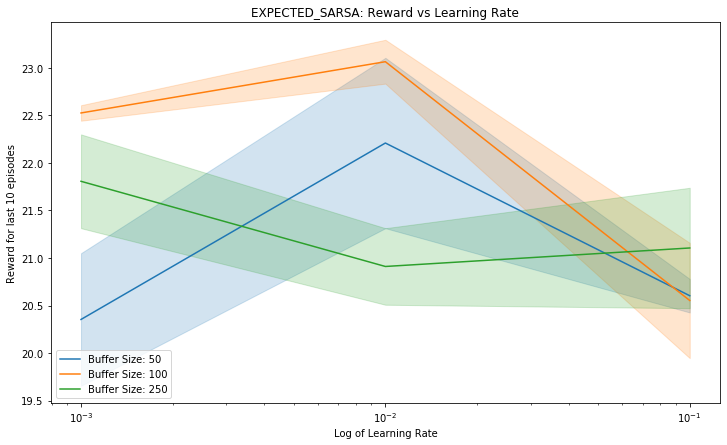

In [177]:
plt.figure(figsize=(12,7))
label = [] 

for key in rewards_buffer_size_dict:
    df = pd.melt(pd.DataFrame(rewards_buffer_size_dict[key]))
    sns.lineplot(x='variable', y='value', data=df)
    label.append('Buffer Size: ' + str(key))

plt.xticks(learning_rate)
plt.xscale("log")
plt.xlabel("Log of Learning Rate")
plt.ylabel("Reward for last 10 episodes")
plt.title("{}: Reward vs Learning Rate".format(algorithm.upper()))

plt.legend(label, loc='lower left');

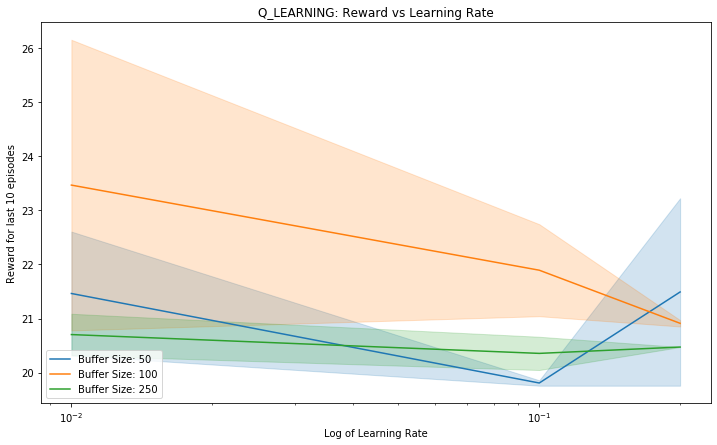

In [0]:
plt.figure(figsize=(12,7))
legend_label = [] 

for key in rewards_buffer_size_dict:
    df = pd.melt(pd.DataFrame(rewards_buffer_size_dict[key]))
    sns.lineplot(x='variable', y='value', data=df)
    legend_label.append('Buffer Size: ' + str(key))

plt.xticks(learning_rate)
plt.xscale("log")
plt.xlabel("Log of Learning Rate")
plt.ylabel("Reward for last 10 episodes")
plt.title("{}: Reward vs Learning Rate".format(algorithm.upper()))

plt.legend(legend_label, loc='lower left');